In [1]:
# Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.formula.api import ols, logit


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
bottle_df = pd.read_csv("../Datasets/bottle.csv",low_memory=False)
cast_df = pd.read_csv("../Datasets/cast.csv",low_memory=False)

In [3]:
display(bottle_df.shape)
cast_df.shape

(864863, 74)

(34404, 61)

#### Cleaning both the data sets by understanding all column values from the below links:
https://new.data.calcofi.org/index.php/database/calcofi-database/bottle-field-descriptions

https://new.data.calcofi.org/index.php/database/calcofi-database/cast-table-column-descriptions


##### For bottle data set:
    - removing all reported value columns as they are duplicates
    
##### For cast data set:
    - removing duplicate columns for Latitude and Longitude in different meausres. Keeping columns measured in degree
    - removing multiple columns for Date and Time and keep one standard "Date" column in format "MM/DD/YYYY"

In [4]:
bottle_cols_to_remove = ['R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA',
       'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3',
       'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP']

bottle_df.drop(bottle_cols_to_remove,axis=1,inplace=True)
bottle_df.shape

(864863, 56)

In [5]:
cast_cols_to_remove = ['Year', 'Month',
       'Julian_Date', 'Julian_Day', 'Lat_Dec','Lat_Min',
       'Lat_Hem', 'Lon_Dec', 'Lon_Min', 'Lon_Hem']
cast_df.drop(cast_cols_to_remove,axis=1,inplace=True)
cast_df.shape

(34404, 51)

##### Merging both datasets

In [6]:
bottle_cast_df = bottle_df.merge(cast_df, on='Cst_Cnt')

In [7]:
bottle_cast_df.shape

(864863, 106)

#### 1.	Perform pre-processing on the full dataset here: https://www.kaggle.com/sohier/calcofi 


##### Handling NaNs

In [8]:
# Delete columns containing either 25% or more than 25% NaN Values
perc = 50
min_count =  int(((100-perc)/100)*bottle_cast_df.shape[0] + 1)
bottle_cast_df.dropna(axis=1, thresh=min_count, inplace=True)

bottle_cast_df.shape

(864863, 59)

In [9]:
col_obj = bottle_cast_df.dtypes[bottle_cast_df.dtypes == object]
bottle_cast_df[col_obj.index].head()

,Sta_ID_x,Depth_ID,Cruise_ID,Cast_ID,Sta_ID_y,Sta_Code,Date,Time,Ship_Name,Ship_Code,Data_Type,Orig_Sta_ID,Data_Or,Cruz_Num
0,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,1949-03-01-C-31CR,19-4903CR-HY-060-0930-05400560,054.0 056.0,NST,03/01/1949,09:30:00,CREST,31CR,HY,054 56,NaN,4903
1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,1949-03-01-C-31CR,19-4903CR-HY-060-0930-05400560,054.0 056.0,NST,03/01/1949,09:30:00,CREST,31CR,HY,054 56,NaN,4903
2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,1949-03-01-C-31CR,19-4903CR-HY-060-0930-05400560,054.0 056.0,NST,03/01/1949,09:30:00,CREST,31CR,HY,054 56,NaN,4903
3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,1949-03-01-C-31CR,19-4903CR-HY-060-0930-05400560,054.0 056.0,NST,03/01/1949,09:30:00,CREST,31CR,HY,054 56,NaN,4903
4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,1949-03-01-C-31CR,19-4903CR-HY-060-0930-05400560,054.0 056.0,NST,03/01/1949,09:30:00,CREST,31CR,HY,054 56,NaN,4903


##### Reducing dataset to numerical only data

In [10]:
bottle_cast_num_df = bottle_cast_df[bottle_cast_df.dtypes.index[bottle_cast_df.dtypes != 'object']]

In [11]:
bottle_cast_num_df.head()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,RecInd,...,St_Station,Ac_Sta,Bottom_D,Event_Num,Wind_Dir,Wind_Spd,Barometer,Dry_T,Wet_T,Wea
0,1,1,0,10.50,33.440,NaN,25.649,NaN,NaN,3,...,56.0,55.8,NaN,1.0,23.0,18.0,NaN,NaN,NaN,2.0
1,1,2,8,10.46,33.440,NaN,25.656,NaN,NaN,3,...,56.0,55.8,NaN,1.0,23.0,18.0,NaN,NaN,NaN,2.0
2,1,3,10,10.46,33.437,NaN,25.654,NaN,NaN,7,...,56.0,55.8,NaN,1.0,23.0,18.0,NaN,NaN,NaN,2.0
3,1,4,19,10.45,33.420,NaN,25.643,NaN,NaN,3,...,56.0,55.8,NaN,1.0,23.0,18.0,NaN,NaN,NaN,2.0
4,1,5,20,10.45,33.421,NaN,25.643,NaN,NaN,7,...,56.0,55.8,NaN,1.0,23.0,18.0,NaN,NaN,NaN,2.0


##### Fill NaNs

In [12]:
bottle_cast_num_df.isna().sum().sort_values(ascending=False)

PO4q           413077
Wet_T          398061
Barometer      397060
Dry_T          396695
Distance       355072
SiO3qu         353997
NO2q           335389
NO3q           334930
Chlqua         225697
Phaqua         225693
Oxy_µmol/Kg    203595
O2Sat          203589
P_qual         191108
Wea            181585
O2ml_L         168662
Bottom_D        59227
NH3q            56564
STheta          52689
Salnty          47354
S_prec          47354
Wind_Spd        28164
Wind_Dir        26947
MeanAq          24424
DarkAq          24423
C14A1q          16258
C14A2q          16240
T_degC          10963
T_prec          10963
Event_Num          66
Cruise              0
St_Station          0
Depthm              0
RecInd              0
Ac_Sta              0
Rpt_Sta             0
Cruz_Sta            0
Ac_Line             0
St_Line             0
Rpt_Line            0
Lon_Deg             0
Lat_Deg             0
Btl_Cnt             0
Quarter             0
DbSta_ID            0
Cst_Cnt             0
dtype: int

In [13]:
col_means = bottle_cast_num_df.mean()

bottle_cast_num_df = bottle_cast_num_df.fillna(col_means)

bottle_cast_num_df.head()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,RecInd,...,St_Station,Ac_Sta,Bottom_D,Event_Num,Wind_Dir,Wind_Spd,Barometer,Dry_T,Wet_T,Wea
0,1,1,0,10.50,33.440,3.392468,25.649,57.103779,148.808694,3,...,56.0,55.8,2583.103636,1.0,23.0,18.0,1016.444375,16.265046,14.436088,2.0
1,1,2,8,10.46,33.440,3.392468,25.656,57.103779,148.808694,3,...,56.0,55.8,2583.103636,1.0,23.0,18.0,1016.444375,16.265046,14.436088,2.0
2,1,3,10,10.46,33.437,3.392468,25.654,57.103779,148.808694,7,...,56.0,55.8,2583.103636,1.0,23.0,18.0,1016.444375,16.265046,14.436088,2.0
3,1,4,19,10.45,33.420,3.392468,25.643,57.103779,148.808694,3,...,56.0,55.8,2583.103636,1.0,23.0,18.0,1016.444375,16.265046,14.436088,2.0
4,1,5,20,10.45,33.421,3.392468,25.643,57.103779,148.808694,7,...,56.0,55.8,2583.103636,1.0,23.0,18.0,1016.444375,16.265046,14.436088,2.0


##### Standardizing the data

In [14]:
scaler = StandardScaler()
bottle_cast_num_df_scaled = pd.DataFrame(scaler.fit_transform(bottle_cast_num_df),columns=bottle_cast_num_df.columns)
bottle_cast_num_df_scaled.head()

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,RecInd,...,St_Station,Ac_Sta,Bottom_D,Event_Num,Wind_Dir,Wind_Spd,Barometer,Dry_T,Wet_T,Wea
0,-1.673458,-1.732049,-0.717709,-0.071067,-0.891606,-4.774785e-16,-0.150570,4.381252e-16,-3.604034e-16,-0.905640,...,-0.305735,-0.295382,6.303787e-16,-1.210091,-0.482293,0.980012,-3.243668e-14,-1.835684e-15,1.887870e-15,0.635373
1,-1.673458,-1.732045,-0.692396,-0.080552,-0.891606,-4.774785e-16,-0.144385,4.381252e-16,-3.604034e-16,-0.905640,...,-0.305735,-0.295382,6.303787e-16,-1.210091,-0.482293,0.980012,-3.243668e-14,-1.835684e-15,1.887870e-15,0.635373
2,-1.673458,-1.732041,-0.686068,-0.080552,-0.898287,-4.774785e-16,-0.146152,4.381252e-16,-3.604034e-16,1.224936,...,-0.305735,-0.295382,6.303787e-16,-1.210091,-0.482293,0.980012,-3.243668e-14,-1.835684e-15,1.887870e-15,0.635373
3,-1.673458,-1.732037,-0.657592,-0.082924,-0.936148,-4.774785e-16,-0.155872,4.381252e-16,-3.604034e-16,-0.905640,...,-0.305735,-0.295382,6.303787e-16,-1.210091,-0.482293,0.980012,-3.243668e-14,-1.835684e-15,1.887870e-15,0.635373
4,-1.673458,-1.732033,-0.654428,-0.082924,-0.933920,-4.774785e-16,-0.155872,4.381252e-16,-3.604034e-16,1.224936,...,-0.305735,-0.295382,6.303787e-16,-1.210091,-0.482293,0.980012,-3.243668e-14,-1.835684e-15,1.887870e-15,0.635373


#### 2.	Perform feature selection (decide what columns should be included in your analysis). How did you figure out what features were important?

* Below I look at the heatmap of the entore dataset. As my target feature is Temperature, I then check for the correlation values for Temp with other features and depending on the values I select 2 of them to perofrm regression

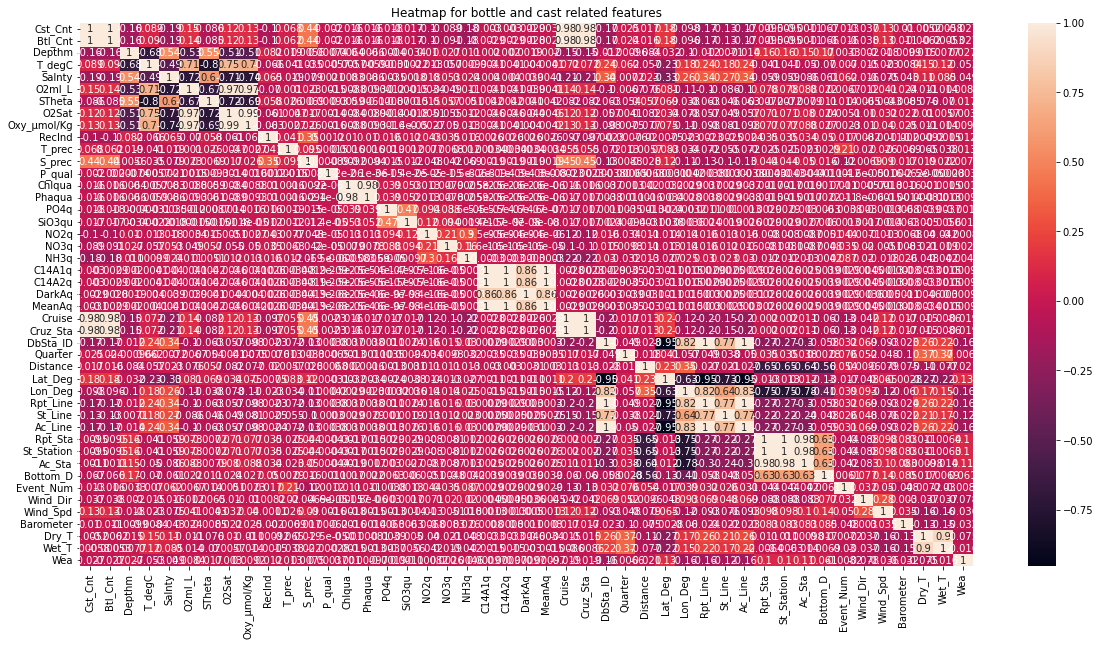

In [15]:
corr = bottle_cast_num_df_scaled.corr()
plt.subplots(1,1,figsize=(20,10))
sns.heatmap(corr, annot=True)
plt.title("Heatmap for bottle and cast related features")
plt.show()

In [16]:
corr = np.abs(corr)
corr[corr['T_degC']>0.5]['T_degC'].sort_values(ascending = False)

T_degC         1.000000
STheta         0.804295
O2Sat          0.745131
O2ml_L         0.712731
Oxy_µmol/Kg    0.696899
Depthm         0.678628
Name: T_degC, dtype: float64

As per above code optimum features to select is 3. Running RFE model mmodel again to get 3 features

#### 3.	Perform multiple linear regression on the dataset. Be sure to display the final resulting equation with the coefficients and intercept in markdown.

In [17]:
mdl_Temp = ols("T_degC ~ Depthm * STheta",data=bottle_cast_num_df_scaled).fit()

In [18]:
mdl_Temp.params

Intercept       -0.159992
Depthm          -0.737626
STheta          -0.400936
Depthm:STheta    0.290005
dtype: float64

* The above regression model can be interpreted as beow formula:

T_degC = (-0.16) + (-0.74) * Depthm + (-0.4) * STheta + 0.29 8 Depthm * STheta

In [19]:
print("R squared value for the model is : ",mdl_Temp.rsquared)

R squared value for the model is :  0.7553858922843387


#### 4.	Which regression approach had the “best” performance? Be sure to compare it to what you did last week.


In [20]:
print("R2 value: ",mdl_Temp.rsquared)
print("RSE: ",np.sqrt(mdl_Temp.mse_resid))

R2 value:  0.7553858922843387
RSE:  0.4945859268757871


* Interepreting the model fit from their R squared values the multiple regression model clearly did better
* The univariate linear regression model from last week's exercise had R2 values of 0.20 while as seen above multiple linear regression model give us the R2 value of 0.75. Which indicates that 75% of data with multiple regression fits the data. 

#### 5.	Work with the diabetes dataset to perform multiple logistic regression.

In [21]:
diabetes_df = pd.read_csv("../Datasets/diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
mdl_outcome = logit("Outcome ~ Age+BMI",data=diabetes_df).fit()

mdl_outcome.params

Optimization terminated successfully.
         Current function value: 0.570101
         Iterations 6


Intercept   -5.403784
Age          0.045608
BMI          0.098250
dtype: float64

Outcome = (-5.4) + 0.045*Age + 0.098*BMI

array([[434.,  66.],
       [175.,  93.]])

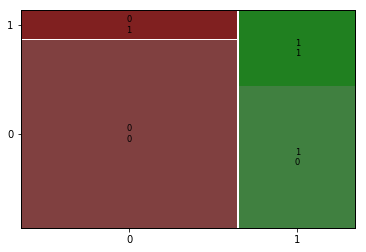

In [23]:
# Calculating accuracy

conf_matrix = mdl_outcome.pred_table()
display(conf_matrix)
mosaic(conf_matrix)
plt.show()

In [24]:
TN=conf_matrix[0,0]
FN=conf_matrix[1,0]
TP=conf_matrix[1,1]
FP=conf_matrix[0,1]

accuracy = (TP+TN)/(TN+TP+FN+FP)
accuracy

0.6861979166666666

In [25]:
mdl_outcome.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Jan 2022   Pseudo R-squ.:                  0.1186
Time:                        00:07:41   Log-Likelihood:                -437.84
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.619e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4038      0.515    -10.487      0.000      -6.414      -4.394
Age            0.0456      0.007      6.571      0.000       0.032       0.059
BMI            0.0982      0.012      7.874      0.000       0.074       0.123
==============================================================================
"""

#### 6.	What are the other ways to assess the performance of the model besides accuracy? What approach makes the most sense with the diabetes dataset? Why? 

* the other ways to assess model performance are:
    - Accuracy — Ratio of correct predictions to total prediction
    - Sensitivity/Recall — Ratio of true positives to total (actual) positives in the data.
    - Precision — Ratio of true positives to total predicted positives.
    - Specificity — Ratio of true negatives to total negatives in the data
    - F1-Score — Considers both precision and recall. It’s the harmonic mean of the precision and recall
    
* In the case of diabetes data identifying the positives are crucial. Hence the best way to assess the model performance should be sensetivity.

In [26]:
sensetivity = TP/(TP+FN)
sensetivity

0.34701492537313433

#### 7.	Tune your model to improve performance based on the performance metric you identified in question 6. Look at the documentation for logistic regression in statsmodel and/or sklearn and see if you can tune the model performance based on available parameters. Please note: data scientists need to constantly learn new approaches to optimizing models. This is one way of doing that.

In [27]:
X=diabetes_df[["Age","BMI"]]
y=diabetes_df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

# Creating the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
  
# Instantiating logistic regression classifier
logreg = LogisticRegression()
  
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
  
mdl_outcome_tune = logreg_cv.fit(X_train, y_train)


array([[135,  22],
       [ 53,  21]], dtype=int64)

Sensetivity score post tuning the model is 0.28378378378378377


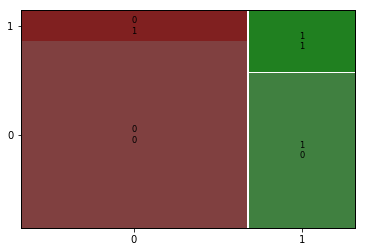

In [28]:
# Testing sensetivity score

y_pred = mdl_outcome_tune.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
display(conf_matrix)
TN=conf_matrix[0,0]
FN=conf_matrix[1,0]
TP=conf_matrix[1,1]
FP=conf_matrix[0,1]

print("Sensetivity score post tuning the model is {}".format(TP/(TP+FN)))
#Display confusion matrix

mosaic(conf_matrix)
plt.show()

#### 8.	Is the KNN model or the multiple logistic regression model more performant for the diabetes dataset? How can you tell? 

* Multiple Logistic Regression seem to be more suited here as with regression we find the most possible outcomes. Regression is able to calculate the probability of the outcome in this case. instead of estimating the binary outcome it calculates the probability of the outcome to be either 0 or 1. 

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train.values, y_train.values)
y_predict = knn.predict(X_test.values)

conf_matrix = confusion_matrix(y_test, y_pred)
display(conf_matrix)

TN=conf_matrix[0,0]
FN=conf_matrix[1,0]
TP=conf_matrix[1,1]
FP=conf_matrix[0,1]

print("Sensetivity score post tuning the model is {}".format(TP/(TP+FN)))

array([[135,  22],
       [ 53,  21]], dtype=int64)

Sensetivity score post tuning the model is 0.28378378378378377


#### DataCamp's Intermediate Regression with statsmodels in Python

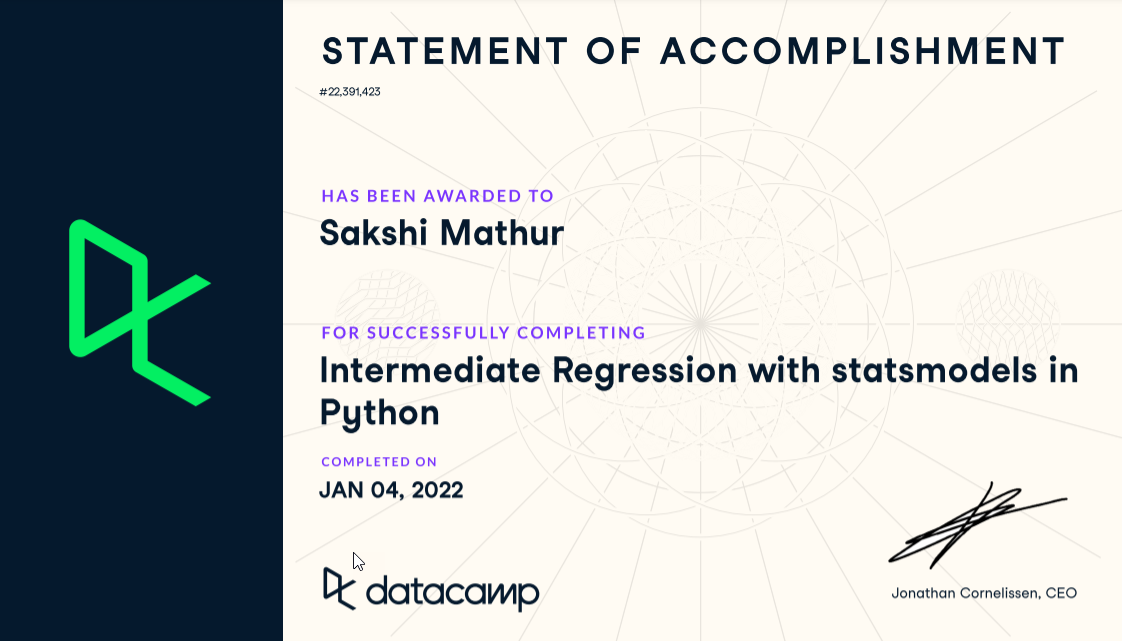